In [1]:
from toolz import curry

import pandas as pd
import numpy as np
from scipy.special import expit

from linearmodels.panel import PanelOLS
import statsmodels.formula.api as smf

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style

style.use("ggplot")

In [2]:
time = range(1980, 2010)
cohorts = [1985,1994,2000,2011]
units = range(1, 100+1)

np.random.seed(3)

df_hom_effect = pd.DataFrame(dict(
    year = np.tile(time, len(units)),
    unit = np.repeat(units, len(time)),
    cohort = np.repeat(np.random.choice(cohorts, len(units)), len(time)),
    unit_fe = np.repeat(np.random.normal(size=len(units)), len(time)),
    time_fe = np.tile(np.random.normal(size=len(time)), len(units)),
)).assign(
    trend = lambda d: (d["year"] - d["year"].min())/8,
    post = lambda d: (d["year"] >= d["cohort"]).astype(int),
).assign(
    treat = 1,
    y0 = lambda d: 10 + d["trend"] + d["unit_fe"] + 0.1*d["time_fe"],
).assign(
    y1 = lambda d: d["y0"] + 1
).assign(
    tau = lambda d: d["y1"] - d["y0"],
    outcome = lambda d: np.where(d["treat"]*d["post"] == 1, d["y1"], d["y0"])
)

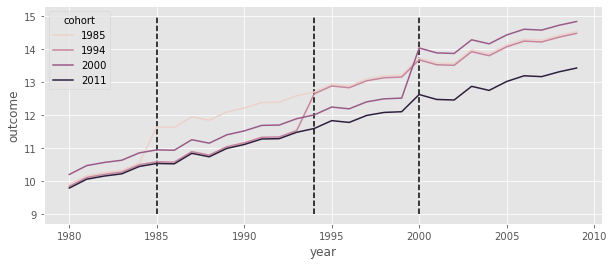

In [3]:
plt.figure(figsize=(10,4))
[plt.vlines(x=c, ymin=9, ymax=15, color="black", ls="dashed") for c in cohorts[:-1]]
sns.lineplot(
    data=df_hom_effect.groupby(["cohort", "year"])["outcome"].mean().reset_index(),
    x="year",
    y = "outcome",
    hue="cohort",
);

In [4]:
formula = f"""outcome ~ treat:post + C(unit) + C(year)"""

mod = smf.ols(formula, data=df_hom_effect)

result = mod.fit()

result.params["treat:post"]

1.0000000000000067

In [5]:
@curry
def demean(df, col_to_demean):
    return df.assign(**{col_to_demean: (df[col_to_demean] -
                                        df.groupby("unit")[col_to_demean].transform("mean")
                                        - df.groupby("year")[col_to_demean].transform("mean"))})

formula = f"""outcome ~ treat_post"""

mod = smf.ols(formula,
              data=df_hom_effect
              .assign(treat_post = df_hom_effect["treat"]*df_hom_effect["post"])
              .pipe(demean(col_to_demean="treat_post")).pipe(demean(col_to_demean="outcome")))

result = mod.fit()

result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-11.8037,4.18e-16,-2.82e+16,0.000,-11.804,-11.804
treat_post,1.0000,7.97e-16,1.25e+15,0.000,1.000,1.000


In [6]:
df_hom_effect.query("treat==1 & post==1")["tau"].mean()

1.0

## Death

## Trend in the Effect

In [7]:
time = range(1980, 2010)
cohorts = [1985,1994,2000,2011]
units = range(1, 100+1)

np.random.seed(3)

df_trend_effect = pd.DataFrame(dict(
    year = np.tile(time, len(units)),
    unit = np.repeat(units, len(time)),
    cohort = np.repeat(np.random.choice(cohorts, len(units)), len(time)),
    unit_fe = np.repeat(np.random.normal(size=len(units)), len(time)),
    time_fe = np.tile(np.random.normal(size=len(time)), len(units)),
)).assign(
    relative_year = lambda d: d["year"] - d["cohort"],
    trend = lambda d: (d["year"] - d["year"].min())/8,
    post = lambda d: (d["year"] >= d["cohort"]).astype(int),
).assign(
    treat = 1,
    y0 = lambda d: 10 + d["unit_fe"] + 0.02*d["time_fe"],
).assign(
    y1 = lambda d: d["y0"] + np.minimum(0.2*(np.maximum(0, d["year"] - d["cohort"])), 1)
).assign(
    tau = lambda d: d["y1"] - d["y0"],
    outcome = lambda d: np.where(d["treat"]*d["post"] == 1, d["y1"], d["y0"])
)

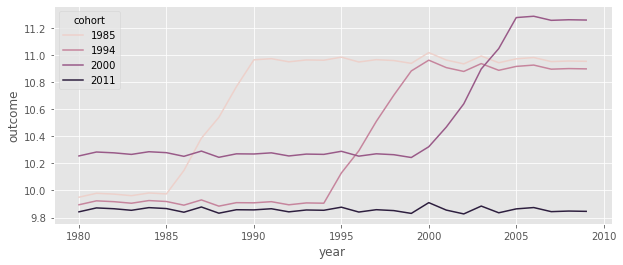

In [8]:
plt.figure(figsize=(10,4))
sns.lineplot(
    data=df_trend_effect.groupby(["cohort", "year"])["outcome"].mean().reset_index(),
    x="year",
    y = "outcome",
    hue="cohort",
);

In [9]:
formula = f"""outcome ~ treat:post + C(year) + C(unit)""" 

mod = smf.ols(formula, data=df_trend_effect)

result = mod.fit()

result.params["treat:post"]

0.6505372592799239

In [10]:
df_trend_effect.query("treat==1 & post==1")["tau"].mean()

0.8293413173652695

### Event Study Desing

In [11]:
relative_years = range(-10,10+1)

formula = "outcome~"+"+".join([f'Q({c})' for c in relative_years]) + "+C(unit)+C(year)"

mod = smf.ols(formula,
              data=(df_trend_effect.join(pd.get_dummies(df_trend_effect["relative_year"]))))

result = mod.fit()

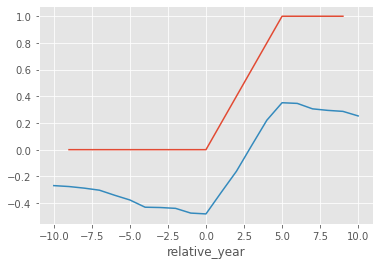

In [12]:
ax = (df_trend_effect
      .query("treat==1")
      .query("relative_year>-10")
      .query("relative_year<10")
      .groupby("relative_year")["tau"].mean().plot())

ax.plot(relative_years, result.params[-len(relative_years):]);

## Covariates

## X-Specific Trends

In [13]:
time = range(1980, 2000)
cohorts = [1990]
units = range(1, 100+1)

np.random.seed(3)

x = np.random.choice(np.random.normal(size=len(units)//10), size=len(units))

df_cov_trend = pd.DataFrame(dict(
    year = np.tile(time, len(units)),
    unit = np.repeat(units, len(time)),
    cohort = np.repeat(np.random.choice(cohorts, len(units)), len(time)),
    unit_fe = np.repeat(np.random.normal(size=len(units)), len(time)),
    time_fe = np.tile(np.random.normal(size=len(time)), len(units)),
    x = np.repeat(x, len(time)),
)).assign(
    trend = lambda d: d["x"]*(d["year"] - d["year"].min())/20,
    post = lambda d: (d["year"] >= d["cohort"]).astype(int),
).assign(
    treat = np.repeat(np.random.binomial(1, expit(x)), len(time)),
    y0 = lambda d: 10 + d["trend"] + 0.5*d["unit_fe"] + 0.01*d["time_fe"],
).assign(
    y1 = lambda d: d["y0"] + 1
).assign(
    tau = lambda d: d["y1"] - d["y0"],
    outcome = lambda d: np.where(d["treat"]*d["post"] == 1, d["y1"], d["y0"])
)

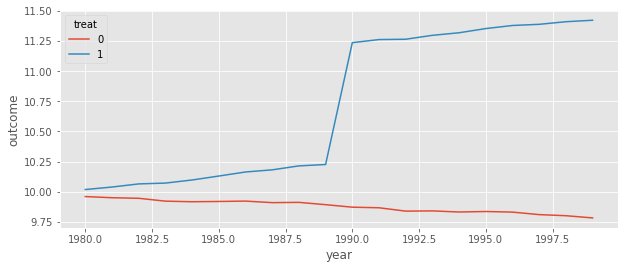

In [14]:
plt.figure(figsize=(10,4))
sns.lineplot(
    data=df_cov_trend.groupby(["treat", "year"])["outcome"].mean().reset_index(),
    x="year",
    y = "outcome",
    hue="treat",
);

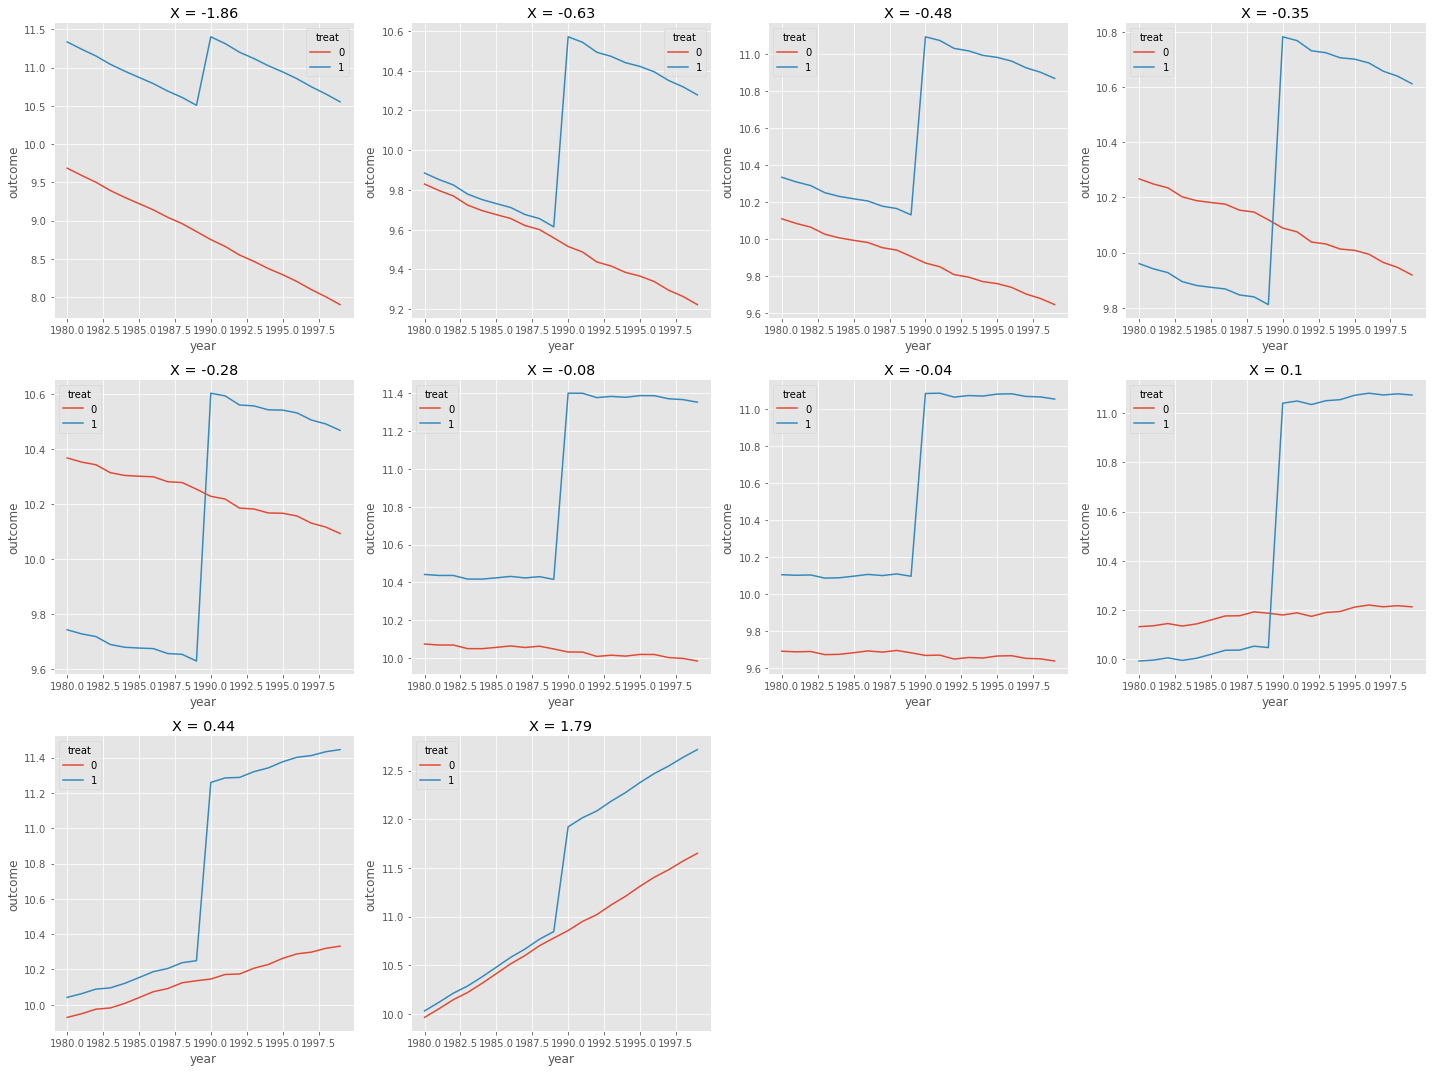

In [15]:
facet_col = "x"
all_facet_values = sorted(df_cov_trend[facet_col].unique())
g = sns.FacetGrid(df_cov_trend, col=facet_col, sharey=False, sharex=False, col_wrap=4, height=5, aspect=1)

for x, ax in zip(all_facet_values, g.axes):
    
    plot_df = df_cov_trend.query(f"{facet_col}=={x}")
    
    sns.lineplot(
        data=plot_df.groupby(["treat", "year"])["outcome"].mean().reset_index(),
        x="year",
        y = "outcome",
        hue="treat",
        ax=ax
    )
    
    ax.set_title(f"X = {round(x, 2)}")    

plt.tight_layout()

In [22]:
formula = f"""outcome ~ treat:post + C(year) + C(unit)""" 

mod = smf.ols(formula, data=df_cov_trend)

result = mod.fit()

result.params["treat:post"]

1.3052744446732731

In [23]:
formula = f"""outcome ~ treat:post + x * C(year) + C(unit)""" 

mod = smf.ols(formula, data=df_cov_trend)

result = mod.fit()

result.params["treat:post"]

0.9999999999999993

In [24]:
df_cov_trend.query("treat==1 & post==1")["tau"].mean()

1.0